## Generalization of selected features to non-carcinoma data types

Do the pan-cancer/median univariate correlations correspond to high correlations on non-carcinoma data types?

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load selected coefficients

In [2]:
# for this analysis we'll just look at the "all other cancers" results
pancancer_only_dir = os.path.join(
    'results', 'purity_binary_median', 'all_other_cancers'
)

In [3]:
all_coefs = []
for coefs_info, coefs_list in au.generate_coefficients_fs_purity(
        pancancer_only_dir, cfg.fs_methods, nonzero_only=False):
    for fold_no, coefs in enumerate(coefs_list):
        fold_info = coefs_info + [fold_no]
        all_coefs.append([fold_info, coefs])
        
print(len(all_coefs))

1320


In [4]:
print(len(all_coefs[0]))
print(all_coefs[0][0], all_coefs[0][1][:5])

2
['DLBC', 'mad', 1000, 1, 0] [('3512', -0.26612), ('714', -0.21247), ('712', -0.17399), ('7316', 0.17222), ('3133', -0.16511)]


In [5]:
# list of sets, one for each feature selection method, of
# features that were selected in at least one cross-validation fold
fs_method_coefs = {}
for coefs_list in all_coefs:
    identifier = '_'.join([str(s) for s in coefs_list[0][:3]])
    features = list(zip(*coefs_list[1]))[0]
    if identifier in fs_method_coefs:
        fs_method_coefs[identifier].update(features)
    else:
        fs_method_coefs[identifier] = set(features)
    
print(list(fs_method_coefs.keys())[:5])

['DLBC_mad_1000', 'UVM_median_f_test_250', 'BLCA_random_250', 'READ_pancan_f_test_250', 'HNSC_mad_250']


### Load gene expression and purity labels

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import pancancer_evaluation.utilities.data_utilities as du

print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

# standardize columns of expression dataframe
# print('Standardizing columns of expression data...', file=sys.stderr)
# rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...


In [7]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,125.0,10.40,136.0,2300.0,1300.0
TCGA-02-0055-01,392.0,1.12,222.0,1820.0,903.0
TCGA-02-2483-01,272.0,4.64,256.0,2890.0,1320.0
TCGA-02-2485-01,83.9,20.00,129.0,6970.0,10100.0
TCGA-02-2486-01,108.0,3.66,205.0,2250.0,873.0


In [12]:
y_df = du.load_purity(mut_burden_df,
                      sample_info_df,
                      classify=True)
y_df.rename(columns={'DISEASE': 'cancer_type'}, inplace=True)

display(y_df.shape, y_df.head())

(8872, 3)

,status,cancer_type,log10_mut
TCGA-02-0047-01,0,GBM,1.812913
TCGA-02-0055-01,0,GBM,1.707570
TCGA-02-2483-01,0,GBM,1.662758
TCGA-02-2485-01,1,GBM,1.748188
TCGA-02-2486-01,0,GBM,1.755875


In [13]:
X_df_unscaled = rnaseq_df.reindex(y_df.index)

X_df = pd.DataFrame(
    StandardScaler().fit_transform(X_df_unscaled),
    index=X_df_unscaled.index.copy(),
    columns=X_df_unscaled.columns.copy()
)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(8872, 16148)

0

,1,10,100,1000,10000
TCGA-02-0047-01,-0.135110,-0.117588,-0.211091,1.011212,0.644120
TCGA-02-0055-01,-0.113814,-0.220135,-0.134790,0.674356,0.164669
TCGA-02-2483-01,-0.123385,-0.181238,-0.104625,1.425263,0.668274
TCGA-02-2485-01,-0.138388,-0.011505,-0.217302,4.288536,11.271737
TCGA-02-2486-01,-0.136466,-0.192067,-0.149873,0.976123,0.128439


In [14]:
def get_f_stats_for_cancer_types(X_df, y_df):
    # calculate pan-cancer and specific-cancer f-statistics
    # (i.e. univariate correlations with labels)
    f_stats_df = {
        'pancan': f_classif(X_df, y_df.status)[0]
    }
    for cancer_type in y_df.cancer_type.unique():
        ct_samples = y_df[y_df.cancer_type == cancer_type].index
        X_ct_df = X_df.reindex(ct_samples)
        y_ct_df = y_df.reindex(ct_samples)
        
        f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
        
    # calculate median specific-cancer f-statistic
    f_stats_df = pd.DataFrame(f_stats_df, index=X_df.columns)
    f_stats_df['median'] = (f_stats_df
        .drop(columns='pancan')
        .median(axis='columns')
    )
        
    return f_stats_df

In [15]:
f_stats_df = get_f_stats_for_cancer_types(X_df, y_df)
print(f_stats_df.columns)
f_stats_df.iloc[:5, -5:]

Index(['pancan', 'GBM', 'OV', 'LUAD', 'LUSC', 'PRAD', 'UCEC', 'BLCA', 'TGCT',
       'ESCA', 'PAAD', 'KIRP', 'LIHC', 'CESC', 'SARC', 'BRCA', 'THYM', 'MESO',
       'COAD', 'STAD', 'SKCM', 'CHOL', 'KIRC', 'THCA', 'HNSC', 'LAML', 'READ',
       'LGG', 'DLBC', 'KICH', 'UCS', 'ACC', 'PCPG', 'UVM', 'median'],
      dtype='object')


,UCS,ACC,PCPG,UVM,median
1,4.058399,0.425023,0.615044,0.428725,1.413299
10,0.006020,1.521468,6.767624,0.965988,0.672985
100,2.136830,0.000624,31.858078,3.609646,5.361308
1000,1.259754,1.596224,4.615656,3.052370,1.462751
10000,0.168254,1.879309,2.928924,0.003206,2.328332


/tmp/ipykernel_5395/1460314479.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[:, 'median'] = (
/tmp/ipykernel_5395/1460314479.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[:, 'pancan'] = (


Text(0.5, 1.0, 'Median vs. pancan f-statistics: $r$: 0.590 ($p =$ 1.208e-49)')

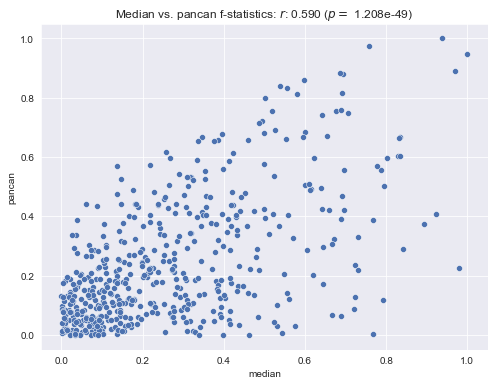

In [16]:
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

sns.set({'figure.figsize': (8, 6)}) 

quantile_cutoff = 0.95

top_median = (
    f_stats_df['median'] > f_stats_df['median'].quantile(q=quantile_cutoff)
)
top_pancan = (
    f_stats_df['pancan'] > f_stats_df['pancan'].quantile(q=quantile_cutoff)
)

scaler = MinMaxScaler()

plot_df = f_stats_df.loc[(top_median & top_pancan), :]
plot_df.loc[:, 'median'] = (
    scaler.fit_transform(plot_df['median'].values.reshape(-1, 1))
)
plot_df.loc[:, 'pancan'] = (
    scaler.fit_transform(plot_df['pancan'].values.reshape(-1, 1))
)

sns.scatterplot(data=plot_df, x='median', y='pancan')

r, pval = pearsonr(plot_df['median'], plot_df['pancan'])
plt.title(r'Median vs. pancan f-statistics: $r$: {:.3f} ($p =$ {:.3e})'.format(r, pval))

In [17]:
# these are "non-carcinoma" cancer types in TCGA
# we anticipate that these will be the hardest to transfer models to (since
# most of TCGA, and thus most of our training set, is generally carcinomas),
# so it's also valuable to look at results filtered only to these
non_carcinomas = [
    'DLBC',
    'GBM',
    'LAML',
    'LGG',
    'SARC',
    'SKCM',
    'TGCT'
]

/tmp/ipykernel_5395/908200386.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median_plot_df.loc[:, 'median'] = (
/tmp/ipykernel_5395/908200386.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancan_plot_df.loc[:, 'pancan'] = (
/tmp/ipykernel_5395/908200386.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

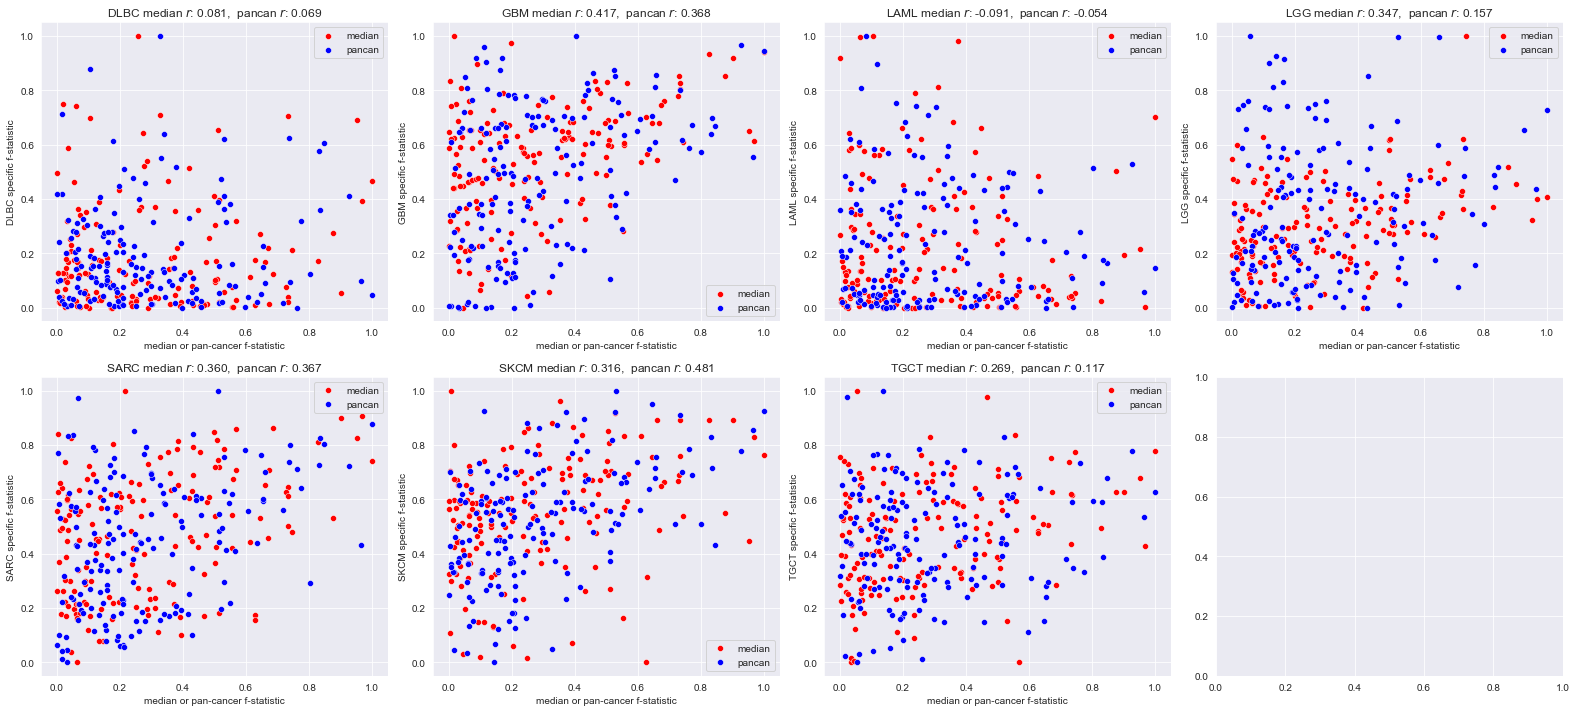

In [22]:
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

sns.set({'figure.figsize': (22, 10)}) 
fig, axarr = plt.subplots(2, 4)

quantile_cutoff = 0.99

scaler = MinMaxScaler()

top_median = (
    f_stats_df['median'] > f_stats_df['median'].quantile(q=quantile_cutoff)
)
top_pancan = (
    f_stats_df['pancan'] > f_stats_df['pancan'].quantile(q=quantile_cutoff)
)

median_plot_df = f_stats_df.loc[top_median, :]
median_plot_df.loc[:, 'median'] = (
    scaler.fit_transform(median_plot_df['median'].values.reshape(-1, 1))
)
pancan_plot_df = f_stats_df.loc[top_pancan, :]
pancan_plot_df.loc[:, 'pancan'] = (
    scaler.fit_transform(pancan_plot_df['pancan'].values.reshape(-1, 1))
)

for ix, cancer_type in enumerate(non_carcinomas):
    ax = axarr[ix // 4, ix % 4]
    median_plot_df.loc[:, cancer_type] = (
        scaler.fit_transform(median_plot_df[cancer_type].values.reshape(-1, 1))
    )
    pancan_plot_df.loc[:, cancer_type] = (
        scaler.fit_transform(pancan_plot_df[cancer_type].values.reshape(-1, 1))
    )

    sns.scatterplot(data=median_plot_df, x='median', y=cancer_type, color='red', label='median', ax=ax)
    sns.scatterplot(data=pancan_plot_df, x='pancan', y=cancer_type, color='blue', label='pancan', ax=ax)

    median_r, median_pval = pearsonr(
        median_plot_df['median'], median_plot_df[cancer_type]
    )
    pancan_r, pancan_pval = pearsonr(
        pancan_plot_df['pancan'], pancan_plot_df[cancer_type]
    )

    ax.set_title(r'{} median $r$: {:.3f},  pancan $r$: {:.3f}'.format(
        cancer_type, median_r, pancan_r ))
    ax.set_xlabel('median or pan-cancer f-statistic')
    ax.set_ylabel('{} specific f-statistic'.format(cancer_type))

plt.tight_layout()

Answer to the question we started with: no, high median (or pan-cancer) f-statistics don't really correlate all that well to high non-carcinoma f-statistics overall. In other words, better overall performance for these feature selection methods does not necessarily come from better univariate correlations on the cancer type of interest - it could be something about the groups of genes we're selecting (e.g. they complement each other better than genes selected by MAD, or cover different pathways better or something) but it doesn't appear to necessarily be driven by the univariate correlation between gene and label itself.